In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image
%matplotlib inline

In [2]:
df = pd.read_csv("Treasury Squeeze raw score data.csv")
df.head()

,rowindex,contract,price_crossing,price_distortion,roll_start,roll_heart,near_minus_next,ctd_last_first,ctd1_percent,delivery_cost,delivery_ratio,squeeze
0,1,TUZ92 Comdty,0.157659,0.900783,0.016053,1.000000,1.000000,0.902811,1.000000,0.010743,0.099313,True
1,2,TUH93 Comdty,0.018588,1.000000,1.000000,0.084724,0.778847,1.000000,0.136069,0.154116,1.000000,False
2,3,TUM93 Comdty,0.035755,0.045987,0.673543,1.000000,0.027689,0.067889,0.007696,0.034743,0.171676,False
3,4,TUU93 Comdty,0.663832,1.000000,0.063057,0.188899,0.064454,0.005742,0.166102,0.956668,1.000000,True
4,5,TUZ93 Comdty,0.109678,0.113601,0.726244,1.000000,1.000000,1.000000,1.000000,0.105467,0.145025,False


In [3]:
# Extract the features and the target variable
X = df[df.columns.values[2:-1]]
y = df['squeeze']
print(X.shape, y.shape)

(900, 9) (900,)


### Implementing Knn

In [4]:
# Standardize X since Knn uses distance
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns.values)
X.shape

(900, 9)

In [5]:
# implement the same parameters as the code presented in Raschka Chapter 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(630, 9) (270, 9)
(630,) (270,)


In [6]:
# Using a for loop to test multiple values of K for your KNN classifier.
# try k=1 to k=25 and record test accuracy score
k_range = range(1, 26)
train_score = []
test_score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_score.append(accuracy_score(y_train, knn.predict(X_train)))  
    test_score.append(accuracy_score(y_test, y_pred))    

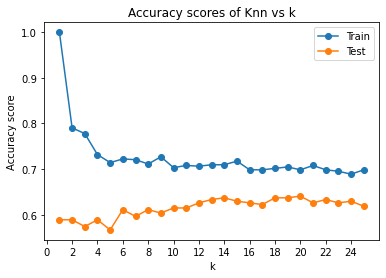

In [7]:
# Plot the results
plt.plot(list(k_range), train_score, 'o-', label = 'Train')
plt.plot(list(k_range), test_score, 'o-', label = 'Test')
plt.xlabel('k')
plt.xticks(range(0,26,2))
plt.ylabel('Accuracy score')
plt.title('Accuracy scores of Knn vs k')
plt.legend()
plt.show()

     It's shown in the figure that when k = 20, the training and testing scores are the closest. Besides, when k = 20, it has the highest testing score. Therefore, it has a decent bias-variance tradeoff.

In [8]:
max_score = np.max(test_score)
optimum_k = np.array(k_range)[test_score == max_score][0]
print('The best accuracy score using a for loop is {}, which is using {} nearest neighbors'.format( \
    np.round(max_score,4), optimum_k))

The best accuracy score using a for loop is 0.6407, which is using 20 nearest neighbors


In [9]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)
print('The mean accuracy score for 5-fold cv with k=20 is:')
print(np.round(np.mean(cross_val_score(knn, X_test, y_test, cv = 5)), 4))
print('The standard deviation for 5-fold cv accuracy score with k=20 is:')
print(np.round(np.std(cross_val_score(knn, X_test, y_test, cv = 5)), 4))

The mean accuracy score for 5-fold cv with k=20 is:
0.6667
The standard deviation for 5-fold cv accuracy score with k=20 is:
0.0828


In [10]:
# Using grid search cross validation to select the best k, weights, and distance matrix
knn_paras = {'n_neighbors':list(range(1, 26)), 
             'weights':['uniform', 'distance'], 
             'metric':['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_paras, scoring = 'accuracy', cv = 5, n_jobs = -1)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [11]:
print('The best training accuracy score using cv is {}'.format(np.round(knn_cv.best_score_, 4)))

The best training accuracy score using cv is 0.6746


In [12]:
print('The best parameters using cv is {}'.format(knn_cv.best_params_))

The best parameters using cv is {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


In [13]:
knn_bestcv = KNeighborsClassifier(n_neighbors = 19, metric = 'manhattan', weights = 'uniform')
knn_bestcv.fit(X_train, y_train)
y_pred = knn_bestcv.predict(X_test)
knn_bestcv_score = accuracy_score(y_test, y_pred)

In [14]:
print('The testing accuracy score using the best parameters is {}'.format(np.round(knn_bestcv_score, 4)))

The testing accuracy score using the best parameters is 0.6185


     It turns out that using a for loop to choose k has a better performance in both the test accuracy score and    the 5-fold cross validation accuracy score than using grid search cv to do hyperparameters tuning. I guess that is due to the fact that the cross validation results has a relatively high standard deviation(roughly 0.083).

### decision tree classifier

In [15]:
# There is no need to standardize the features
# implement the same parameters as the code presented in Raschka Chapter 3
X = df[df.columns.values[2:-1]]
y = df['squeeze']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(630, 9) (270, 9)
(630,) (270,)


In [16]:
# implement the same parameters as the code presented in Raschka Chapter 3
tree = DecisionTreeClassifier(criterion = 'gini', 
                              max_depth = 4, 
                              random_state = 1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [17]:
print('The accuracy score for the test set is ', np.round(accuracy_score(y_test, tree.predict(X_test)), 4))

The accuracy score for the test set is  0.5889


In [18]:
print('The accuracy score for the test set with 5-fold cross validation is ', \
      np.round(np.mean(cross_val_score(tree, X_test, y_test, cv = 5)), 4))

The accuracy score for the test set with 5-fold cross validation is  0.6259


In [19]:
# Using grid search cross validation to select the best parameters
tree_paras = {'max_depth':list(range(1, 10))}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, tree_paras, scoring = 'accuracy', cv = 5, n_jobs = -1)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [20]:
print('The best training accuracy score using cv is {}'.format(np.round(tree_cv.best_score_, 4)))

The best training accuracy score using cv is 0.6762


In [21]:
print('The best parameters using cv is {}'.format(tree_cv.best_params_))

The best parameters using cv is {'max_depth': 4}


In [22]:
tree = DecisionTreeClassifier(max_depth = 4)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
tree_bestcv_score = accuracy_score(y_test, y_pred)

In [23]:
print('The testing accuracy score using the best parameters is {}'.format(np.round(tree_bestcv_score, 4)))

The testing accuracy score using the best parameters is 0.5889


In [24]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['True', 
                                        'False'],
                           feature_names=X.columns.values,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')

True

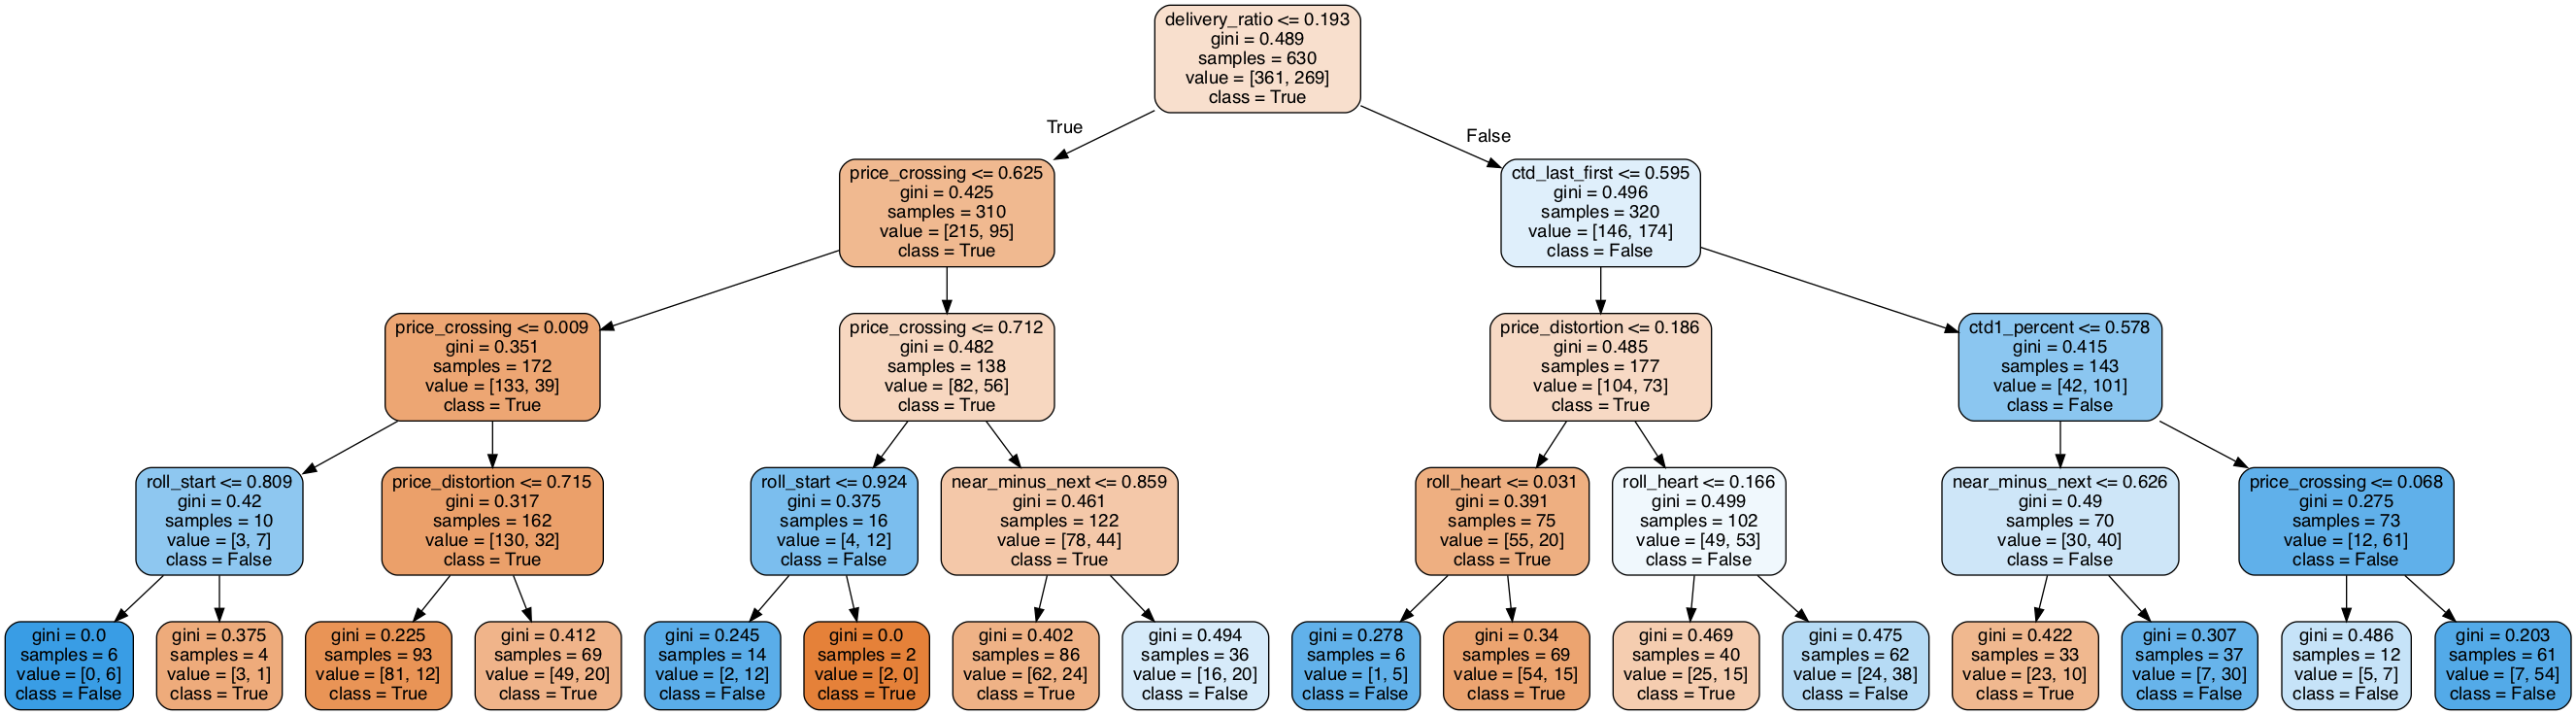

In [25]:
# Display the tree structure
Image(filename='tree.png', width=1000)

In [26]:
print("My name is {Jinglun Gao}")
print("My NetID is: {jinglun3}")
print("I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.")

My name is {Jinglun Gao}
My NetID is: {jinglun3}
I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.
